<a href="https://colab.research.google.com/github/mattsouza0/Reconhecimento-de-face/blob/master/AED3IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Acurácia do reconhecimento facial: 0.6875
Exemplos aleatorios de rostos e suas eigenfaces


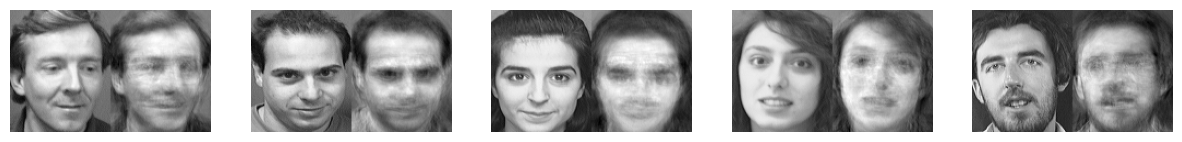

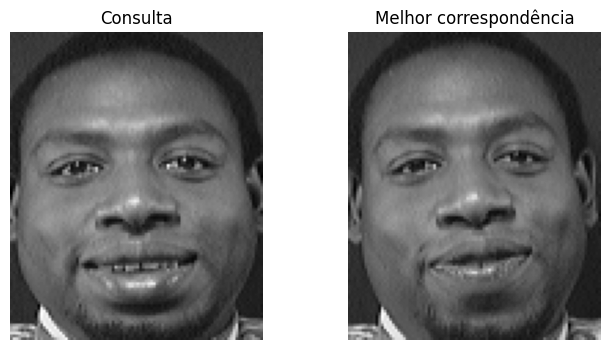

In [15]:
# importação da bibliotecas necessárias

import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Carrega o arquivo .zip das imagens e logo após extrai
caminho_zip = '/content/sample_data/orl_faces.zip'
with zipfile.ZipFile(caminho_zip, 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data')

#Função para calcular o erro (RMS)
def calcular_erro(original, reconstruido):
    return np.sqrt(((original - reconstruido) ** 2).mean())

# Representação de uma imagem discreta de face;
rostos = []
rotulos = []

# altura e largura
altura, largura = cv2.imread("/content/sample_data/orl_faces/s1/1.pgm", cv2.IMREAD_GRAYSCALE).shape;

for sujeito in range(1, 41):
    for num_img in range(1, 11):
        caminho = f"/content/sample_data/orl_faces/s{sujeito}/{num_img}.pgm"
        img = cv2.imread(caminho, cv2.IMREAD_GRAYSCALE)
        rostos.append(img.flatten())
        rotulos.append(sujeito)

X = np.array(rostos)
y = np.array(rotulos)

# Divide o conjunto de dados em treinamento e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)

# Lista para armazenar os erros (RMS) para diferentes números de PCs
erros_rms = []

# Redução da dimensionalidade dos dados

# Números de PCs para teste
num_pcs_teste = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for num_pcs in num_pcs_teste:
    # Reduz a dimensionalidade aplicando PCA
    pca = PCA(n_components=num_pcs, whiten=True)
    #3 fit_transform realiza a decomposição da matriz de covariância para calcular os autovetores e autovalores.
    X_treino_pca = pca.fit_transform(X_treino)
    X_teste_pca = pca.transform(X_teste)

    # Treina um classificador KNN
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_treino_pca, y_treino)

    # Faz previsões no conjunto de teste
    y_pred = knn.predict(X_teste_pca)

    # Calcula o erro (RMS) para cada imagem de teste
    erros_individuais = []
    for i in range(len(X_teste)):
        rosto_original = X_teste[i]
        rosto_reconstruido = pca.inverse_transform(X_teste_pca[i])
        erro_rms = calcular_erro(rosto_original, rosto_reconstruido)
        erros_individuais.append(erro_rms)

    # Calcula o erro médio (RMS) para o conjunto de teste
    erro_rms_medio = np.mean(erros_individuais)
    erros_rms.append(erro_rms_medio)

# Calcula a precisão
acuracia = accuracy_score(y_teste, y_pred)
print(f"Acurácia do reconhecimento facial: {acuracia}")

# Exibe alguns rostos e suas reconstruções após a PCA
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    indice_aleatorio = np.random.randint(0, len(X_teste))
    rosto_original = X_teste[indice_aleatorio].reshape((altura, largura))
    rosto_reconstruido = pca.inverse_transform(X_teste_pca[indice_aleatorio]).reshape((altura, largura))

    axes[i].imshow(np.hstack([rosto_original, rosto_reconstruido]), cmap="gray")
    axes[i].axis('off')

print("Exemplos aleatorios de rostos e suas eigenfaces")
plt.show()

# Encontrar o número mínimo de PCs com base no menor erro RMS
num_pcs_otimo = num_pcs_teste[np.argmin(erros_rms)]

# Reduz a dimensionalidade aplicando PCA com o número ótimo de PCs
pca_otimo = PCA(n_components=num_pcs_otimo, whiten=True)
X_treino_pca_otimo = pca_otimo.fit_transform(X_treino)
X_teste_pca_otimo = pca_otimo.transform(X_teste)

# Treina um classificador KNN com o número ótimo de PCs
knn_otimo = KNeighborsClassifier(n_neighbors=5)
knn_otimo.fit(X_treino_pca_otimo, y_treino)

# Faz a consulta em rostos
consulta = X_teste[3].reshape(1, -1)
consulta_pca = pca_otimo.transform(consulta)

# Encontrar a melhor correspondência
melhor_correspondencia = knn_otimo.predict(consulta_pca)[0]

# Exibir a imagem de consulta e a melhor correspondência
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(consulta.reshape((altura, largura)), cmap="gray")
axes[0].set_title("Consulta")
axes[0].axis('off')

imagem_correspondencia = X_treino[y_treino == melhor_correspondencia][0].reshape((altura, largura))
axes[1].imshow(imagem_correspondencia, cmap="gray")
axes[1].set_title("Melhor correspondência")
axes[1].axis('off')

plt.show()